In [1]:
import cv2
import numpy as np
from pathlib import Path
import os, shutil
from os import listdir
import matplotlib.pyplot as plt
from scipy import stats
import pickle
import pandas as pd
from pandas import Series, DataFrame

In [2]:
images_dir_true = Path(r"C:\Users\g_bab\Downloads\dataCLASSES_wo_rocket_body").expanduser()
labels_imgs = []
count = 0
for z in range(len(listdir(images_dir_true))):
    im = np.load(os.path.join(images_dir_true, "real_set"+str(z+1)+".npy"))
    labels_imgs.append(im)

In [23]:
img_data = [i for i in range(len(labels_imgs))]     
print(len(img_data))
onehotslist = []
for label in img_data:
    blank = np.zeros(len(img_data))
    blank[label] = 1
    onehotslist.append(blank)
#print(onehotslist)
onehots_dict = {img_data[i]:onehotslist[i] for i in range(len(img_data))}
#print(onehots_dict)

126


In [4]:
images_dir = Path(r"C:\Users\g_bab\Downloads\data_wo_rocket_body").expanduser()

xtest_data = []
count = 0
for k in range(len(listdir(images_dir))):
    im = np.load(os.path.join(images_dir, "train_set"+str(k+1)+".npy"))
    xtest_data.append(im)


In [5]:
for i in xtest_data:
    if i.shape != (100,100,3):
        print("wrong shape")

126


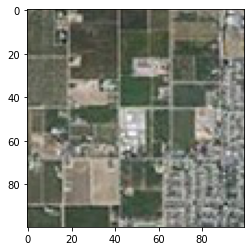

In [6]:
fig, ax = plt.subplots()
count=0 
for i in range(len(labels_imgs)):
    ax.imshow(labels_imgs[i])
    count+=1
print(count)

In [24]:
keypointslist = []       #will have number of classes number of keypoints
descriptorslist = []     #will have number of classes number of descriptor vectors   <-- important thing

sift = cv2.xfeatures2d.SIFT_create()

for i in labels_imgs:
    #img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)    might uncomment later

    #sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(i,None)
    
    keypointslist.append(keypoints)
    descriptorslist.append(descriptors)
    #print(len(keypoints))
    

In [8]:
len(xtest_data)

12600

In [10]:
#test with all distorted images and see how many guesses come back right (basically just checking if it works)
#bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
acc_count = 0
killed_imgs = 0

sift = cv2.SIFT_create()
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

for i in range(len(xtest_data)-11000):  #for each test image  (-11k to not have to go through entire dataset)
    test_keypoints, test_descriptors = sift.detectAndCompute(xtest_data[i],None)      #calculate descriptor of that image
    matches_counts = []
    if test_descriptors is None:
        print("no descriptor")
        killed_imgs+=1
        continue
    for j in descriptorslist:                      #compare that discriptor with every descriptor of the 126 classifying images
        #matches = bf.match(j,test_descriptors)  
        matches = flann.knnMatch(j,test_descriptors,k=2)  
        good = []
        for m,n in matches:
            if m.distance < 0.6*n.distance:
                good.append(m)
        matches_counts.append(len(good))        
        
    guess = np.argmax(matches_counts)              #return which classifying image most matched the test image
    
    if np.argmax(onehots_dict[i%len(labels_imgs)]) == guess:      #if the guess is the same as the label, mark as correct
        acc_count+=1
        

In [11]:
final_accuracy = acc_count/(len(xtest_data)-11000-killed_imgs) #given 1600 agumented images, the algorithm identified the correct match 97% of the time
print(final_accuracy)

0.97


In [22]:
#RASPBERRY PI 4 IMPLEMENTATION

#gather all images with Pi cam, put them into a numpy array

pi_cam_imgs = []
pi_cam_imgs.append(xtest_data[1])
pi_cam_imgs.append(xtest_data[0])
pi_cam_imgs.append(xtest_data[1])

guesses = []

acc_count = 0

sift = cv2.SIFT_create()
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

for i in range(len(pi_cam_imgs)):  #for each pi cam image
    test_keypoints, test_descriptors = sift.detectAndCompute(pi_cam_imgs[i],None)      #calculate descriptor of that image
    matches_counts = []
    if test_descriptors is None:
        print("no descriptor")
        continue
    for j in descriptorslist:                      #compare that discriptor with every descriptor of the 126 classifying images
        #matches = bf.match(j,test_descriptors)  
        matches = flann.knnMatch(j,test_descriptors,k=2)  
        good = []
        for m,n in matches:
            if m.distance < 0.6*n.distance:
                good.append(m)
        matches_counts.append(len(good))        
        
    guess = np.argmax(matches_counts)              #return which classifying image most matched the test image
    guesses.append(guess)

final_mode = stats.mode(guesses)
final_guess = final_mode[0][0]
print(final_guess)

1
